<a href="https://colab.research.google.com/github/Sxmuu/TG-Samuel-P/blob/main/Scripts/Python/Notebooks/ML/Modelos_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Ingeniería de Variables**

In [1]:
# --- Importaciones ---
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 200)

# Utilidad: reindexar por día dentro de cada estación para ventanas móviles estrictas
def reindex_daily_per_station(df, station_col='Estacion', date_col='Date'):
    out = []
    for est, dfg in df.groupby(station_col, sort=False):
        dfg = dfg.sort_values(date_col).copy()
        idx = pd.date_range(dfg[date_col].min(), dfg[date_col].max(), freq='D')
        dfg = dfg.set_index(date_col).reindex(idx).rename_axis(date_col).reset_index()
        dfg[station_col] = est
        out.append(dfg)
    return pd.concat(out, ignore_index=True)


In [2]:
url = "https://raw.githubusercontent.com/Sxmuu/TG-Samuel-P/main/Databases/Contam/Final/df_final.xlsx"

df = pd.read_excel(url, engine="openpyxl")  # instala openpyxl si hace falta

In [3]:
expected_cols = ['Date','Estacion','Localidad','PM25','lat','lon','Altitud',
                 'Pres','Precip','Hum','Temp','WindSpeed']
missing = [c for c in expected_cols if c not in df.columns]
if missing:
    raise ValueError(f"Faltan columnas esperadas: {missing}")

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.sort_values(['Estacion','Date']).drop_duplicates(subset=['Estacion','Date']).reset_index(drop=True)

print(df[['Estacion','Date']].groupby('Estacion').agg(['min','max','nunique']).head())


                                 Date                   
                                  min        max nunique
Estacion                                                
Centro De Alto Rendimiento 2021-01-01 2024-12-30    1460
Ciudad Bolivar             2021-01-01 2024-12-30    1460
Colina                     2021-01-15 2024-12-30    1446
Fontibon                   2021-01-01 2024-12-30    1460
Guaymaral                  2021-01-01 2024-12-30    1460


In [4]:
# --- 2) (Opcional) Reindexar a diario por estación ---
# Si ya sabes que todas las estaciones tienen una observación por día, puedes saltarte esto.
# Si no, esto asegura ventanas móviles de longitud exacta (introducirá NaN si faltaban días).
df = reindex_daily_per_station(df, station_col='Estacion', date_col='Date')


In [5]:
# --- 2) Tipos y orden temporal ---
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
# (Opcional) Orden global
df = df.sort_values(['Estacion', 'Date']).reset_index(drop=True)

# (Opcional) Quitar duplicados exactos por Estacion-Fecha (si existieran)
df = df.drop_duplicates(subset=['Estacion','Date'])
print(df[['Estacion','Date']].groupby('Estacion').agg(['min','max','nunique']).head())

                                 Date                   
                                  min        max nunique
Estacion                                                
Centro De Alto Rendimiento 2021-01-01 2024-12-30    1460
Ciudad Bolivar             2021-01-01 2024-12-30    1460
Colina                     2021-01-15 2024-12-30    1446
Fontibon                   2021-01-01 2024-12-30    1460
Guaymaral                  2021-01-01 2024-12-30    1460


In [6]:
# --- 3) Calendario y estacionalidad ---
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['dayofyear'] = df['Date'].dt.dayofyear
df['dow'] = df['Date'].dt.dayofweek
df['is_weekend'] = (df['dow'] >= 5).astype(int)
df['sin_doy'] = np.sin(2*np.pi*df['dayofyear']/365.25)
df['cos_doy'] = np.cos(2*np.pi*df['dayofyear']/365.25)

In [7]:
# --- 4) Funciones de lags y rolling (sin fuga) ---
def add_lags(df, group_key, date_col, vars_to_lag, lags):
    df = df.sort_values([group_key, date_col]).copy()
    for var in vars_to_lag:
        for k in lags:
            df[f'{var}_lag{k}'] = df.groupby(group_key, sort=False)[var].shift(k)
    return df

def add_rolling_features(df, group_key, date_col, var, windows, stats=('mean',), shift_one=True):
    df = df.sort_values([group_key, date_col]).copy()
    base = df.groupby(group_key, sort=False)[var]
    series = base.shift(1) if shift_one else base.transform(lambda x: x)
    for w in windows:
        roll = series.rolling(w)
        if 'mean' in stats:
            df[f'{var}_rollmean{w}'] = roll.mean().reset_index(level=0, drop=True)
        if 'std' in stats:
            df[f'{var}_rollstd{w}'] = roll.std().reset_index(level=0, drop=True)
        if 'min' in stats:
            df[f'{var}_rollmin{w}'] = roll.min().reset_index(level=0, drop=True)
        if 'max' in stats:
            df[f'{var}_rollmax{w}'] = roll.max().reset_index(level=0, drop=True)
    return df


In [8]:
# --- 5) Lags y rolling de PM25 (clave para 2026) ---
lags_pm25 = [1, 3, 7]
wins_pm25 = [3, 7]

df_feat = add_lags(df, group_key='Estacion', date_col='Date',
                   vars_to_lag=['PM25'], lags=lags_pm25)

df_feat = add_rolling_features(df_feat, group_key='Estacion', date_col='Date',
                               var='PM25', windows=wins_pm25,
                               stats=('mean',), shift_one=True)


In [9]:
# --- 6) (Opcional) Lags de meteorología (sí disponibles si tienes meteo 2026 o usarás climatología)
include_meteo_lags = True
meteo_vars = ['Temp','Hum','WindSpeed','Precip','Pres']
if include_meteo_lags:
    df_feat = add_lags(df_feat, group_key='Estacion', date_col='Date',
                       vars_to_lag=meteo_vars, lags=[1, 3])


In [10]:
# --- 8) Limpieza por NaN de bordes (debidos a lags/rolling) ---
rows_before = len(df_feat)
df_model = df_feat.dropna(subset=['PM25_lag1','PM25_rollmean3']).reset_index(drop=True)
rows_after = len(df_model)
print(f"Filas antes: {rows_before:,} | después de dropna: {rows_after:,} | perdidas: {rows_before - rows_after:,}")


Filas antes: 21,803 | después de dropna: 20,000 | perdidas: 1,803


In [11]:
# --- 9) Columnas finales para modelado (no entrenamos aún) ---
base_cols = ['Date','Estacion','Localidad','lat','lon','Altitud','PM25',
             'year','month','dayofyear','dow','is_weekend','sin_doy','cos_doy']
lag_cols = [c for c in df_model.columns if c.startswith('PM25_lag') or c.startswith('PM25_rollmean')]
met_lag_cols = [c for c in df_model.columns if any(c.startswith(v+'_lag') for v in meteo_vars)]

cols_for_next_steps = base_cols + lag_cols + met_lag_cols
df_ready = df_model[cols_for_next_steps].copy()

print("Columnas finales (primeras 25):")
print(df_ready.columns.tolist()[:25], '...')
df_ready.head()


Columnas finales (primeras 25):
['Date', 'Estacion', 'Localidad', 'lat', 'lon', 'Altitud', 'PM25', 'year', 'month', 'dayofyear', 'dow', 'is_weekend', 'sin_doy', 'cos_doy', 'PM25_lag1', 'PM25_lag3', 'PM25_lag7', 'PM25_rollmean3', 'PM25_rollmean7', 'Temp_lag1', 'Temp_lag3', 'Hum_lag1', 'Hum_lag3', 'WindSpeed_lag1', 'WindSpeed_lag3'] ...


,Date,Estacion,Localidad,lat,lon,Altitud,PM25,year,month,dayofyear,dow,is_weekend,sin_doy,cos_doy,PM25_lag1,PM25_lag3,PM25_lag7,PM25_rollmean3,PM25_rollmean7,Temp_lag1,Temp_lag3,Hum_lag1,Hum_lag3,WindSpeed_lag1,WindSpeed_lag3,Precip_lag1,Precip_lag3,Pres_lag1,Pres_lag3
0,2021-01-05,Centro De Alto Rendimiento,Barrios Unidos,4.65847,-74.08396,2552,13.739130,2021,1,5,1,0,0.085906,0.996303,8.541667,6.500000,NaN,7.222222,NaN,18.37,19.64,81.29,77.80,1.17,0.75,12.97,3.90,82.18,82.28
1,2021-01-06,Centro De Alto Rendimiento,Barrios Unidos,4.65847,-74.08396,2552,15.208333,2021,1,6,2,0,0.103031,0.994678,13.739130,6.625000,NaN,9.635266,NaN,17.87,18.16,78.17,84.79,0.99,0.77,2.28,11.61,82.20,82.26
2,2021-01-07,Centro De Alto Rendimiento,Barrios Unidos,4.65847,-74.08396,2552,8.583333,2021,1,7,3,0,0.120126,0.992759,15.208333,8.541667,NaN,12.496377,NaN,17.92,18.37,77.14,81.29,0.68,1.17,1.89,12.97,82.30,82.18
3,2021-01-08,Centro De Alto Rendimiento,Barrios Unidos,4.65847,-74.08396,2552,12.437500,2021,1,8,4,0,0.137185,0.990545,8.583333,13.739130,NaN,12.510266,NaN,18.81,17.87,75.35,78.17,0.66,0.99,3.63,2.28,82.34,82.20
4,2021-01-09,Centro De Alto Rendimiento,Barrios Unidos,4.65847,-74.08396,2552,3.000000,2021,1,9,5,1,0.154204,0.988039,12.437500,15.208333,6.5,12.076389,10.233566,17.88,17.92,80.50,77.14,0.60,0.68,0.94,1.89,82.35,82.30


In [12]:
# --- 10) Guardar dataset de características ---
df_ready.to_csv('df_features_PM25_no_copollutants.csv', index=False)
print("✅ Guardado: df_features_PM25_no_copollutants.csv")


✅ Guardado: df_features_PM25_no_copollutants.csv


In [13]:
# --- Climatología meteo por estación y día-del-año (mediana) ---
years_hist = [2021, 2022, 2023, 2024]   # ajusta si procede
meteo_vars = ['Temp','Hum','WindSpeed','Precip','Pres']

df_hist = df[df['year'].isin(years_hist)].copy()
df_hist['doy'] = df_hist['Date'].dt.dayofyear

clima = (df_hist.groupby(['Estacion','doy'])[meteo_vars]
         .median()
         .reset_index()
         .rename(columns={v: f'{v}_clim' for v in meteo_vars}))

# Construir calendario 2026 y “pegar” climatología por estación y DOY
cal2026 = pd.date_range('2026-01-01','2026-12-31',freq='D')
cal = (pd.DataFrame({'Date': cal2026})
       .assign(doy=lambda x: x['Date'].dt.dayofyear)
      )

# Ejemplo: climatología para todas las estaciones (repetimos por estación)
ests = df['Estacion'].dropna().unique()
clima2026 = (cal.assign(key=1)
               .merge(pd.DataFrame({'Estacion': ests, 'key':1}), on='key')
               .drop(columns='key')
               .merge(clima, on=['Estacion','doy'], how='left'))

clima2026.to_csv('climatologia_meteo_2026_por_estacion.csv', index=False)
print("✅ Guardado: climatologia_meteo_2026_por_estacion.csv (medianas por DOY y estación)")


✅ Guardado: climatologia_meteo_2026_por_estacion.csv (medianas por DOY y estación)


##**Validación Cruzada**

In [14]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error



df = df_ready.copy()
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Chequeo rápido:
print(df.shape)
print(df[['Date','Estacion','Localidad']].head(3))


(20000, 29)
        Date                    Estacion       Localidad
0 2021-01-05  Centro De Alto Rendimiento  Barrios Unidos
1 2021-01-06  Centro De Alto Rendimiento  Barrios Unidos
2 2021-01-07  Centro De Alto Rendimiento  Barrios Unidos


In [15]:
# Columnas base (ajusta si cambiaste nombres)
base_cols = ['Date','Localidad','lat','lon','Altitud','PM25',
             'year','month','dayofyear','dow','is_weekend','sin_doy','cos_doy']

# Lags/rollings ya construidos en Paso 1
lag_cols = [c for c in df.columns if c.startswith('PM25_lag') or c.startswith('PM25_rollmean')]
# Lags meteo si los añadiste en Paso 1
met_vars = ['Temp','Hum','WindSpeed','Precip','Pres']
met_lag_cols = [c for c in df.columns if any(c.startswith(v+'_lag') for v in met_vars)]

# Sin copolutantes:
feature_cols = ['Localidad','lat','lon','Altitud',
                'year','month','dayofyear','dow','is_weekend','sin_doy','cos_doy'] \
               + lag_cols + met_lag_cols

# Quitar filas con NaN en features/target (bordes por lags)
data = df.dropna(subset=feature_cols + ['PM25']).copy()

X = data[feature_cols].copy()
y = data['PM25'].values
dates = data['Date'].copy()
localities = data['Localidad'].copy()

# Preprocesamiento: OHE para categóricas; numéricas 'passthrough'
cat_features = ['Localidad']
num_features = [c for c in feature_cols if c not in cat_features]

pre = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features),
    ('num', 'passthrough', num_features)
])


In [16]:
model = HistGradientBoostingRegressor(
    learning_rate=0.06,
    max_iter=400,
    min_samples_leaf=25,
    early_stopping=True,
    random_state=42
)

pipe = Pipeline([
    ('pre', pre),
    ('model', model)
])


In [17]:
def build_time_folds(unique_dates, n_folds=4):
    """
    Forward-chaining con validación por bloques de igual tamaño aproximado.
    Devuelve lista de dicts con índices booleanos para train/val.
    """
    unique_dates = np.array(sorted(unique_dates))
    folds = []
    val_block = int(len(unique_dates)/(n_folds+1))
    for k in range(1, n_folds+1):
        train_end = k*val_block
        val_start = train_end
        val_end = val_start + val_block
        train_dates = unique_dates[:train_end]
        val_dates = unique_dates[val_start:val_end]
        folds.append({
            "train_dates": train_dates,
            "val_dates": val_dates
        })
    return folds

unique_days = np.array(sorted(dates.dt.normalize().unique()))
folds = build_time_folds(unique_days, n_folds=4)
[(f["train_dates"].min(), f["train_dates"].max(), f["val_dates"].min(), f["val_dates"].max()) for f in folds]


[(Timestamp('2021-01-08 00:00:00'),
  Timestamp('2021-10-24 00:00:00'),
  Timestamp('2021-10-25 00:00:00'),
  Timestamp('2022-08-10 00:00:00')),
 (Timestamp('2021-01-08 00:00:00'),
  Timestamp('2022-08-10 00:00:00'),
  Timestamp('2022-08-11 00:00:00'),
  Timestamp('2023-05-27 00:00:00')),
 (Timestamp('2021-01-08 00:00:00'),
  Timestamp('2023-05-27 00:00:00'),
  Timestamp('2023-05-28 00:00:00'),
  Timestamp('2024-03-12 00:00:00')),
 (Timestamp('2021-01-08 00:00:00'),
  Timestamp('2024-03-12 00:00:00'),
  Timestamp('2024-03-13 00:00:00'),
  Timestamp('2024-12-27 00:00:00'))]

In [18]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import sklearn
print("scikit-learn versión:", sklearn.__version__)

def rmse_compat(y_true, y_pred):
    """RMSE compatible con cualquier versión de scikit-learn."""
    try:
        # sklearn >= 0.22 (aprox.) soporta 'squared'
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        # fallback para versiones antiguas
        return np.sqrt(mean_squared_error(y_true, y_pred))


scikit-learn versión: 1.6.1


In [19]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def rmse_compat(y_true, y_pred):
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        return np.sqrt(mean_squared_error(y_true, y_pred))

# Cambiar agrupamiento de 'Estacion' a 'Localidad'
def eval_by_locality(y_true, y_pred, localities):
    dfm = pd.DataFrame({"y": y_true, "yhat": y_pred, "Localidad": localities})  # Cambio aquí
    out = []
    for loc, g in dfm.groupby("Localidad", sort=False):  # Cambiar 'Estacion' por 'Localidad'
        mae = mean_absolute_error(g["y"], g["yhat"])
        rmse = rmse_compat(g["y"], g["yhat"])   # Calculamos RMSE
        out.append({"Localidad": loc, "MAE": mae, "RMSE": rmse, "n": len(g)})  # Cambiar 'Estacion' por 'Localidad'
    return pd.DataFrame(out).sort_values("RMSE")

# Cambiar 'stations' a 'localities'
cv_rows = []
per_locality_reports = []

for i, f in enumerate(folds, start=1):
    tr_mask = dates.dt.normalize().isin(f["train_dates"])
    va_mask = dates.dt.normalize().isin(f["val_dates"])

    X_tr, y_tr = X[tr_mask], y[tr_mask]
    X_va, y_va = X[va_mask], y[va_mask]
    locality_va = localities[va_mask].values  # Usamos 'localities' aquí en lugar de 'stations'

    pipe.fit(X_tr, y_tr)
    pred_va = pipe.predict(X_va)

    mae = mean_absolute_error(y_va, pred_va)
    rmse = rmse_compat(y_va, pred_va)  # Calculamos RMSE

    cv_rows.append({
        "fold": i,
        "train_start": str(dates[tr_mask].min().date()),
        "train_end":   str(dates[tr_mask].max().date()),
        "val_start":   str(dates[va_mask].min().date()),
        "val_end":     str(dates[va_mask].max().date()),
        "n_train": int(tr_mask.sum()),
        "n_val": int(va_mask.sum()),
        "MAE": mae,
        "RMSE": rmse
    })

    # Usamos la nueva función con 'Localidad'
    rep = eval_by_locality(y_va, pred_va, locality_va)
    rep.insert(0, 'fold', i)
    per_locality_reports.append(rep)

cv_table = pd.DataFrame(cv_rows)
per_locality_table = pd.concat(per_locality_reports, ignore_index=True)

display(cv_table.round(3))
display(per_locality_table.round(3))

# Guardamos los resultados
cv_table.to_csv("cv_temporal_global.csv", index=False)
per_locality_table.to_csv("cv_temporal_por_localidad.csv", index=False)
print("✅ Guardados: cv_temporal_global.csv, cv_temporal_por_localidad.csv")


,fold,train_start,train_end,val_start,val_end,n_train,n_val,MAE,RMSE
0,1,2021-01-08,2021-10-24,2021-10-25,2022-08-10,3464,3737,4.313,5.588
1,2,2021-01-08,2022-08-10,2022-08-11,2023-05-27,7201,3743,4.510,5.855
2,3,2021-01-08,2023-05-27,2023-05-28,2024-03-12,10944,3800,4.310,5.599
3,4,2021-01-08,2024-03-12,2024-03-13,2024-12-27,14744,3621,3.887,5.157


,fold,Localidad,MAE,RMSE,n
0,1,Suba,3.494,4.542,626
1,1,Barrios Unidos,3.971,4.933,262
2,1,Engativa,4.041,5.160,202
3,1,Kennedy,4.274,5.363,280
4,1,Santa Fe,4.201,5.444,262
5,1,Puente Aranda,4.287,5.454,510
6,1,San Cristobal,4.098,5.501,270
7,1,Fontibon,4.729,5.884,533
8,1,Tunjuelito,4.794,6.140,271
9,1,Usme,4.806,6.409,239


✅ Guardados: cv_temporal_global.csv, cv_temporal_por_localidad.csv


In [20]:
mask_train = dates.dt.year <= 2023
mask_test  = dates.dt.year == 2024

X_tr, y_tr = X[mask_train], y[mask_train]
X_te, y_te = X[mask_test],  y[mask_test]
localities_te = localities[mask_test].values  # Cambiar 'stations' por 'localities'

pipe.fit(X_tr, y_tr)
pred_te = pipe.predict(X_te)

mae_te = mean_absolute_error(y_te, pred_te)
rmse_te = rmse_compat(y_te, pred_te)  # Calculando RMSE sin squared=False
print(f"Hold-out 2024 → MAE: {mae_te:.3f} | RMSE: {rmse_te:.3f} | n_test: {mask_test.sum()}")

# Evaluar por localidad en vez de estación
rep_te = eval_by_locality(y_te, pred_te, localities_te).round(3)  # Usar eval_by_locality
display(rep_te)

# Guardar el resultado con nombre modificado
rep_te.to_csv("holdout2024_por_localidad.csv", index=False)
print("✅ Guardado: holdout2024_por_localidad.csv")

Hold-out 2024 → MAE: 4.383 | RMSE: 5.587 | n_test: 4571


,Localidad,MAE,RMSE,n
2,Suba,3.483,4.572,912
9,Tunjuelito,3.919,4.903,297
8,San Cristobal,3.941,5.047,295
0,Barrios Unidos,4.128,5.280,268
6,Engativa,4.139,5.428,236
10,Usme,4.171,5.478,323
5,Kennedy,4.466,5.677,303
7,Santa Fe,4.518,5.757,320
3,Fontibon,4.781,6.130,642
4,Puente Aranda,5.399,6.157,630


✅ Guardado: holdout2024_por_localidad.csv


In [21]:
# Repite el armado del fold 4 exactamente como en tu CV
fold = folds[3]  # 4º fold (índice 3)
tr_mask = dates.dt.normalize().isin(fold["train_dates"])
va_mask = dates.dt.normalize().isin(fold["val_dates"])

pipe.fit(X[tr_mask], y[tr_mask])
pred_va = pipe.predict(X[va_mask])

df_va = data.loc[va_mask, ['Date','Localidad','PM25']].copy()  # Cambiar 'Estacion' por 'Localidad'
df_va['yhat'] = pred_va
df_va['abs_err'] = (df_va['PM25'] - df_va['yhat']).abs()

# Modificar la función para agrupar por 'Localidad' en vez de 'Estacion'
def mae_rmse(g):
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    import numpy as np
    try:
        rmse = mean_squared_error(g['PM25'], g['yhat'], squared=False)
    except TypeError:
        rmse = np.sqrt(mean_squared_error(g['PM25'], g['yhat']))
    return pd.Series({
        'n': len(g),
        'MAE': mean_absolute_error(g['PM25'], g['yhat']),
        'RMSE': rmse
    })

# Agrupar por 'Localidad' en vez de 'Estacion'
print(df_va.groupby('Localidad').apply(mae_rmse).round(3))

# Si quieres ver la distribución de errores de Usaquen (ahora por localidad)
usa = df_va[df_va['Localidad'] == 'Puente Aranda']  # Cambiar 'Estacion' por 'Localidad'
print(usa[['abs_err']].describe(percentiles=[.5,.9,.95,.99]).round(3).T)
print("Fechas con mayor error en Puente Aranda:\n", usa.nlargest(5, 'abs_err')[['Date', 'PM25', 'yhat', 'abs_err']])


                    n    MAE   RMSE
Localidad                          
Barrios Unidos  221.0  3.908  5.147
Ciudad Bolivar  280.0  4.962  6.579
Engativa        206.0  4.090  5.427
Fontibon        511.0  4.656  6.013
Kennedy         246.0  4.306  5.543
Puente Aranda   480.0  3.162  4.310
San Cristobal   229.0  3.577  4.594
Santa Fe        245.0  4.040  5.229
Suba            707.0  3.333  4.416
Tunjuelito      238.0  3.637  4.613
Usme            258.0  3.840  5.181
         count   mean    std    min   50%   90%    95%     99%     max
abs_err  480.0  3.162  2.932  0.013  2.38  6.69  9.182  14.847  17.647
Fechas con mayor error en Puente Aranda:
            Date       PM25       yhat    abs_err
7771 2024-03-23  48.570833  30.923671  17.647162
7793 2024-04-18  44.983333  28.024774  16.958560
7770 2024-03-22  48.000000  31.296767  16.703233
7844 2024-06-14  24.756522   9.852365  14.904156
7989 2024-11-20  29.604167  14.735397  14.868770


/tmp/ipython-input-2936231327.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  print(df_va.groupby('Localidad').apply(mae_rmse).round(3))


##**CatBoost**

In [22]:
# ==== 0) Setup: instalar CatBoost (si hiciera falta) ====
!pip -q install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 24.7 MB/s eta 0:00:00


In [23]:
# ==== 1) Cargar librerías y datos ====
import json, math, random
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor, Pool

# Compatibilidad de métricas (RMSE con y sin 'squared')
from sklearn.metrics import mean_absolute_error, mean_squared_error
def rmse_compat(y_true, y_pred):
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        return np.sqrt(mean_squared_error(y_true, y_pred))

df = df_ready.copy()
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Solo por seguridad: tipar categóricas como string
for c in ['Localidad']:  # Cambiar 'Estacion' por 'Localidad'
    if c in df.columns:
        df[c] = df[c].astype(str)

print(df.shape)
df.head(2)


(20000, 29)


,Date,Estacion,Localidad,lat,lon,Altitud,PM25,year,month,dayofyear,dow,is_weekend,sin_doy,cos_doy,PM25_lag1,PM25_lag3,PM25_lag7,PM25_rollmean3,PM25_rollmean7,Temp_lag1,Temp_lag3,Hum_lag1,Hum_lag3,WindSpeed_lag1,WindSpeed_lag3,Precip_lag1,Precip_lag3,Pres_lag1,Pres_lag3
0,2021-01-05,Centro De Alto Rendimiento,Barrios Unidos,4.65847,-74.08396,2552,13.739130,2021,1,5,1,0,0.085906,0.996303,8.541667,6.500,NaN,7.222222,NaN,18.37,19.64,81.29,77.80,1.17,0.75,12.97,3.90,82.18,82.28
1,2021-01-06,Centro De Alto Rendimiento,Barrios Unidos,4.65847,-74.08396,2552,15.208333,2021,1,6,2,0,0.103031,0.994678,13.739130,6.625,NaN,9.635266,NaN,17.87,18.16,78.17,84.79,0.99,0.77,2.28,11.61,82.20,82.26


In [24]:
# ==== 2) Definir features y target (sin copolutantes) ====
base_cols = ['Date','Localidad','lat','lon','Altitud',  # Cambiar 'Estacion' por 'Localidad'
             'year','month','dayofyear','dow','is_weekend','sin_doy','cos_doy']

lag_cols = [c for c in df.columns if c.startswith('PM25_lag') or c.startswith('PM25_rollmean')]

met_vars = ['Temp','Hum','WindSpeed','Precip','Pres']
met_lag_cols = [c for c in df.columns if any(c.startswith(v+'_lag') for v in met_vars)]

# target
target_col = 'PM25'

# columnas finales de X (Date no va al modelo)
feature_cols = ['Localidad','lat','lon','Altitud',  # Cambiar 'Estacion' por 'Localidad'
                'year','month','dayofyear','dow','is_weekend','sin_doy','cos_doy'] \
               + lag_cols + met_lag_cols

data = df.dropna(subset=feature_cols + [target_col]).copy()
X = data[feature_cols].copy()
y = data[target_col].values
dates = data['Date'].copy()
localities = data['Localidad'].copy()  # Cambiar 'Estacion' por 'Localidad'

# Índices de categóricas para CatBoost (dentro de X)
cat_cols = ['Localidad']  # Cambiar 'Estacion' por 'Localidad'
cat_idx = [X.columns.get_loc(c) for c in cat_cols if c in X.columns]

len(feature_cols), feature_cols[:8], cat_idx


(26,
 ['Localidad', 'lat', 'lon', 'Altitud', 'year', 'month', 'dayofyear', 'dow'],
 [0])

In [25]:
# ==== 3) Construir los mismos folds temporales (ventana expansiva) ====
def build_time_folds(unique_dates, n_folds=4):
    unique_dates = np.array(sorted(unique_dates))
    folds = []
    val_block = int(len(unique_dates)/(n_folds+1))
    for k in range(1, n_folds+1):
        train_end = k*val_block
        val_start = train_end
        val_end = val_start + val_block
        train_dates = unique_dates[:train_end]
        val_dates = unique_dates[val_start:val_end]
        folds.append({"train_dates": train_dates, "val_dates": val_dates})
    return folds

unique_days = np.array(sorted(dates.dt.normalize().unique()))
folds = build_time_folds(unique_days, n_folds=4)

[(f["train_dates"].min(), f["train_dates"].max(), f["val_dates"].min(), f["val_dates"].max()) for f in folds]


[(Timestamp('2021-01-08 00:00:00'),
  Timestamp('2021-10-24 00:00:00'),
  Timestamp('2021-10-25 00:00:00'),
  Timestamp('2022-08-10 00:00:00')),
 (Timestamp('2021-01-08 00:00:00'),
  Timestamp('2022-08-10 00:00:00'),
  Timestamp('2022-08-11 00:00:00'),
  Timestamp('2023-05-27 00:00:00')),
 (Timestamp('2021-01-08 00:00:00'),
  Timestamp('2023-05-27 00:00:00'),
  Timestamp('2023-05-28 00:00:00'),
  Timestamp('2024-03-12 00:00:00')),
 (Timestamp('2021-01-08 00:00:00'),
  Timestamp('2024-03-12 00:00:00'),
  Timestamp('2024-03-13 00:00:00'),
  Timestamp('2024-12-27 00:00:00'))]

In [26]:
# ==== 4) Función de evaluación para un set de hiperparámetros ====
def eval_params(params, verbose=False):
    """Devuelve dict con MAE y RMSE promediados en CV, y por fold."""
    fold_results = []
    for i, f in enumerate(folds, start=1):
        tr_mask = dates.dt.normalize().isin(f["train_dates"])
        va_mask = dates.dt.normalize().isin(f["val_dates"])

        X_tr, y_tr = X[tr_mask], y[tr_mask]
        X_va, y_va = X[va_mask], y[va_mask]

        train_pool = Pool(X_tr, y_tr, cat_features=cat_idx)
        valid_pool = Pool(X_va, y_va, cat_features=cat_idx)

        model = CatBoostRegressor(
            loss_function='RMSE',
            iterations=params.get('iterations', 2000),
            depth=params.get('depth', 7),
            learning_rate=params.get('learning_rate', 0.06),
            l2_leaf_reg=params.get('l2_leaf_reg', 3.0),
            bootstrap_type=params.get('bootstrap_type', 'Bayesian'),
            bagging_temperature=params.get('bagging_temperature', 1.0),
            random_strength=params.get('random_strength', 0.0),
            early_stopping_rounds=params.get('early_stopping_rounds', 100),
            random_seed=42,
            verbose=False,
            allow_writing_files=False
        )

        model.fit(train_pool, eval_set=valid_pool, use_best_model=True, verbose=verbose)
        pred_va = model.predict(valid_pool)

        mae = mean_absolute_error(y_va, pred_va)
        rmse = rmse_compat(y_va, pred_va)

        fold_results.append({"fold": i, "MAE": mae, "RMSE": rmse, "n_val": int(va_mask.sum())})

    mae_mean = float(np.mean([r["MAE"] for r in fold_results]))
    rmse_mean = float(np.mean([r["RMSE"] for r in fold_results]))
    return {"mae_mean": mae_mean, "rmse_mean": rmse_mean, "folds": fold_results}


In [27]:
# ==== 5) Random Search liviano de hiperparámetros ====
random.seed(42)
search_space = {
    "depth":       [5,6,7,8,9,10],
    "learning_rate": [0.02, 0.03, 0.04, 0.06, 0.08, 0.10],
    "l2_leaf_reg":  [1.0, 2.0, 3.0, 5.0, 7.0, 10.0],
    "bagging_temperature": [0.0, 0.5, 1.0, 2.0, 3.0, 5.0],
    "random_strength": [0.0, 0.1, 0.2, 0.5],
    "iterations":  [1500, 2000, 2500],
    "bootstrap_type": ['Bayesian'],
    "early_stopping_rounds": [100]
}

def sample_params(space):
    return {
        "depth": random.choice(space["depth"]),
        "learning_rate": random.choice(space["learning_rate"]),
        "l2_leaf_reg": random.choice(space["l2_leaf_reg"]),
        "bagging_temperature": random.choice(space["bagging_temperature"]),
        "random_strength": random.choice(space["random_strength"]),
        "iterations": random.choice(space["iterations"]),
        "bootstrap_type": 'Bayesian',
        "early_stopping_rounds": 100
    }

results = []
N_TRIALS = 50  # puedes subirlo si tienes tiempo de cómputo
for t in range(1, N_TRIALS+1):
    params = sample_params(search_space)
    res = eval_params(params, verbose=False)
    res["params"] = params
    results.append(res)
    print(f"Trial {t}/{N_TRIALS} → RMSE_CV={res['rmse_mean']:.3f} | MAE_CV={res['mae_mean']:.3f} | {params}")

# Ordenar por RMSE (menor es mejor)
results_sorted = sorted(results, key=lambda r: r["rmse_mean"])
best = results_sorted[0]
print("\n=== MEJOR CONFIGURACIÓN (CV) ===")
print(json.dumps(best["params"], indent=2))
print("CV → RMSE promedio:", round(best["rmse_mean"],3), " | MAE promedio:", round(best["mae_mean"],3))
pd.DataFrame(best["folds"]).round(3)


Trial 1/50 → RMSE_CV=5.706 | MAE_CV=4.386 | {'depth': 10, 'learning_rate': 0.02, 'l2_leaf_reg': 1.0, 'bagging_temperature': 5.0, 'random_strength': 0.2, 'iterations': 1500, 'bootstrap_type': 'Bayesian', 'early_stopping_rounds': 100}
Trial 2/50 → RMSE_CV=5.473 | MAE_CV=4.198 | {'depth': 6, 'learning_rate': 0.03, 'l2_leaf_reg': 10.0, 'bagging_temperature': 0.0, 'random_strength': 0.0, 'iterations': 2500, 'bootstrap_type': 'Bayesian', 'early_stopping_rounds': 100}
Trial 3/50 → RMSE_CV=5.484 | MAE_CV=4.210 | {'depth': 8, 'learning_rate': 0.02, 'l2_leaf_reg': 1.0, 'bagging_temperature': 0.0, 'random_strength': 0.1, 'iterations': 1500, 'bootstrap_type': 'Bayesian', 'early_stopping_rounds': 100}
Trial 4/50 → RMSE_CV=5.586 | MAE_CV=4.290 | {'depth': 9, 'learning_rate': 0.08, 'l2_leaf_reg': 1.0, 'bagging_temperature': 3.0, 'random_strength': 0.1, 'iterations': 2500, 'bootstrap_type': 'Bayesian', 'early_stopping_rounds': 100}
Trial 5/50 → RMSE_CV=5.668 | MAE_CV=4.364 | {'depth': 10, 'learning_ra

,fold,MAE,RMSE,n_val
0,1,4.114,5.315,3737
1,2,4.416,5.717,3743
2,3,4.141,5.414,3800
3,4,3.882,5.065,3621


In [28]:
# ==== 6) Reentrenar con mejor set (2021–2023) y evaluar en 2024 (hold-out) ====
mask_train = (dates.dt.year <= 2023)
mask_test  = (dates.dt.year == 2024)

X_tr, y_tr = X[mask_train], y[mask_train]
X_te, y_te = X[mask_test],  y[mask_test]

train_pool = Pool(X_tr, y_tr, cat_features=cat_idx)
test_pool  = Pool(X_te, y_te, cat_features=cat_idx)

best_params = best["params"].copy()
final_model = CatBoostRegressor(
    loss_function='RMSE',
    iterations=best_params["iterations"],
    depth=best_params["depth"],
    learning_rate=best_params["learning_rate"],
    l2_leaf_reg=best_params["l2_leaf_reg"],
    bootstrap_type='Bayesian',
    bagging_temperature=best_params["bagging_temperature"],
    random_strength=best_params["random_strength"],
    early_stopping_rounds=100,
    random_seed=42,
    verbose=False,
    allow_writing_files=False
)

# Usamos un pequeño conjunto de validación (último mes de 2023) para early stopping del final_model
cutoff = pd.Timestamp('2023-12-01')
tr_in  = dates[mask_train] < cutoff
tr_val = (dates[mask_train] >= cutoff)

final_model.fit(
    Pool(X_tr[tr_in],  y_tr[tr_in],  cat_features=cat_idx),
    eval_set=Pool(X_tr[tr_val], y_tr[tr_val], cat_features=cat_idx),
    use_best_model=True, verbose=False
)

pred_te = final_model.predict(test_pool)
mae_te = mean_absolute_error(y_te, pred_te)
rmse_te = rmse_compat(y_te, pred_te)
print(f"Hold-out 2024 → MAE: {mae_te:.3f} | RMSE: {rmse_te:.3f} | n_test: {int(mask_test.sum())}")

# Guardar predicciones 2024
out_te = data.loc[mask_test, ['Date','Localidad',target_col]].copy()  # Cambiar 'Estacion' por 'Localidad'
out_te['yhat'] = pred_te
out_te.to_csv('predicciones_holdout2024_catboost.csv', index=False)

# Métricas por localidad (2024) - Cambiar 'Estacion' por 'Localidad'
by_locality = out_te.groupby('Localidad').apply(  # Cambiar 'Estacion' por 'Localidad'
    lambda g: pd.Series({
        'n': len(g),
        'MAE': mean_absolute_error(g[target_col], g['yhat']),
        'RMSE': rmse_compat(g[target_col], g['yhat'])
    })
).reset_index().sort_values('RMSE')
by_locality.round(3)


Hold-out 2024 → MAE: 4.373 | RMSE: 5.627 | n_test: 4571


/tmp/ipython-input-312011496.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  by_locality = out_te.groupby('Localidad').apply(  # Cambiar 'Estacion' por 'Localidad'


,Localidad,n,MAE,RMSE
9,Tunjuelito,297.0,3.461,4.289
8,Suba,912.0,3.465,4.613
6,San Cristobal,295.0,3.786,4.877
10,Usme,323.0,3.969,5.214
0,Barrios Unidos,268.0,4.090,5.235
2,Engativa,236.0,3.900,5.325
4,Kennedy,303.0,4.157,5.349
7,Santa Fe,320.0,4.167,5.611
3,Fontibon,642.0,4.785,6.217
1,Ciudad Bolivar,345.0,5.165,6.650


In [29]:
# ==== 7) Importancias de variables y guardado del modelo ====
# Importancia "Feature Importance" de CatBoost (Gain)
fi = final_model.get_feature_importance(train_pool, type='FeatureImportance')
fi_df = pd.DataFrame({'feature': X.columns, 'importance': fi}).sort_values('importance', ascending=False)
fi_df.to_csv('feature_importance_catboost.csv', index=False)

# Guardar modelo y parámetros
final_model.save_model('catboost_pm25_model.cbm')
with open('best_params_catboost.json','w') as f:
    json.dump(best_params, f, indent=2)

print("✅ Guardados: catboost_pm25_model.cbm, best_params_catboost.json, feature_importance_catboost.csv, predicciones_holdout2024_catboost.csv")
fi_df.head(15)


✅ Guardados: catboost_pm25_model.cbm, best_params_catboost.json, feature_importance_catboost.csv, predicciones_holdout2024_catboost.csv


,feature,importance
11,PM25_lag1,32.619815
22,Precip_lag1,6.301874
7,dow,6.169645
10,cos_doy,5.309504
15,PM25_rollmean7,4.395434
20,WindSpeed_lag1,4.330960
6,dayofyear,3.618320
18,Hum_lag1,3.477777
9,sin_doy,3.426289
19,Hum_lag3,3.280537


In [44]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, median_absolute_error
import numpy as np # Import numpy for np.sqrt

def regression_metrics(y_true, y_pred, eps=1e-8):
    """Devuelve R², RMSE, MAE, MDAE, MAPE(%) y MPE(%) para un par y_true/y_pred.
       Para MAPE/MPE se ignoran observaciones con |y_true| < eps."""
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    err = y_pred - y_true

    # Use rmse_compat to handle different sklearn versions
    try:
        rmse = mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    mae  = mean_absolute_error(y_true, y_pred)
    mdae = median_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)

    denom = np.where(np.abs(y_true) < eps, np.nan, y_true)
    ape = np.abs(err) / np.abs(denom) * 100.0  # %
    pe  = err / denom * 100.0                  # %

    mape = float(np.nanmean(ape))
    mpe  = float(np.nanmean(pe))

    return {
        "R²": r2,
        "RMSE": rmse,
        "MAE": mae,
        "MDAE": mdae,
        "MAPE": mape,
        "MPE": mpe,
        "n": int(len(y_true)),
        "n_pct_used": int(np.isfinite(ape).sum())  # obs usadas en MAPE/MPE
    }

In [42]:
from sklearn.metrics import r2_score

# --- 1) Evaluación de varianza explicada (R²) para cada fold y hold-out 2024 ---
def evaluate_r2(y_true, y_pred):
    """Calcula R² (varianza explicada) global."""
    return r2_score(y_true, y_pred)

# --- 2) Evaluación en los folds de la CV temporal ---
def eval_r2_params(params, verbose=False):
    """Devuelve el R² promedio en CV y por fold."""
    fold_results = []
    for i, f in enumerate(folds, start=1):
        tr_mask = dates.dt.normalize().isin(f["train_dates"])
        va_mask = dates.dt.normalize().isin(f["val_dates"])

        X_tr, y_tr = X[tr_mask], y[tr_mask]
        X_va, y_va = X[va_mask], y[va_mask]

        train_pool = Pool(X_tr, y_tr, cat_features=cat_idx)
        valid_pool = Pool(X_va, y_va, cat_features=cat_idx)

        model = CatBoostRegressor(
            loss_function='RMSE',
            iterations=params.get('iterations', 2000),
            depth=params.get('depth', 7),
            learning_rate=params.get('learning_rate', 0.06),
            l2_leaf_reg=params.get('l2_leaf_reg', 3.0),
            bootstrap_type='Bayesian',
            bagging_temperature=params.get('bagging_temperature', 1.0),
            random_strength=params.get('random_strength', 0.0),
            early_stopping_rounds=100,
            random_seed=42,
            verbose=False,
            allow_writing_files=False
        )
        model.fit(train_pool, eval_set=valid_pool, use_best_model=True, verbose=verbose)

        # Predicciones para R² (validación)
        yhat_va = model.predict(valid_pool)

        # Calcular R² por fold
        r2 = evaluate_r2(y_va, yhat_va)

        fold_results.append({"fold": i, "R²": r2, "n_val": int(va_mask.sum())})

    r2_mean = float(np.mean([r["R²"] for r in fold_results]))
    return {"r2_mean": r2_mean, "folds": fold_results}

# Evaluación del mejor modelo (con parámetros encontrados en la búsqueda)
r2_result = eval_r2_params(best["params"])
print("CV (varianza explicada R²) → R² promedio:", round(r2_result["r2_mean"],3))
pd.DataFrame(r2_result["folds"]).round(3)


CV (varianza explicada R²) → R² promedio: 0.588


,fold,R²,n_val
0,1,0.521,3737
1,2,0.476,3743
2,3,0.630,3800
3,4,0.724,3621


In [45]:
from sklearn.metrics import r2_score

# --- 1) Evaluación de varianza explicada (R²) para cada fold y hold-out 2024 ---
def evaluate_r2(y_true, y_pred):
    """Calcula R² (varianza explicada) global."""
    return r2_score(y_true, y_pred)

# --- 2) Evaluación en los folds de la CV temporal ---
def eval_r2_params(params, verbose=False):
    fold_results = []
    for i, f in enumerate(folds, start=1):
        tr_mask = dates.dt.normalize().isin(f["train_dates"])
        va_mask = dates.dt.normalize().isin(f["val_dates"])

        X_tr, y_tr = X[tr_mask], y[tr_mask]
        X_va, y_va = X[va_mask], y[va_mask]

        train_pool = Pool(X_tr, y_tr, cat_features=cat_idx)
        valid_pool = Pool(X_va, y_va, cat_features=cat_idx)

        model = CatBoostRegressor(
            loss_function='RMSE',
            iterations=params.get('iterations', 2000),
            depth=params.get('depth', 7),
            learning_rate=params.get('learning_rate', 0.06),
            l2_leaf_reg=params.get('l2_leaf_reg', 3.0),
            bootstrap_type='Bayesian',
            bagging_temperature=params.get('bagging_temperature', 1.0),
            random_strength=params.get('random_strength', 0.0),
            early_stopping_rounds=100,
            random_seed=42,
            verbose=False,
            allow_writing_files=False
        )
        model.fit(train_pool, eval_set=valid_pool, use_best_model=True, verbose=verbose)

        yhat_va = model.predict(valid_pool)
        m = regression_metrics(y_va, yhat_va)
        m.update({"fold": i, "n_val": int(va_mask.sum())})
        fold_results.append(m)

    # Promedios
    cols = ["R²", "RMSE", "MAE", "MDAE", "MAPE", "MPE"]
    mean_simple = {k: float(np.mean([fr[k] for fr in fold_results])) for k in cols}
    weights = np.array([fr["n_val"] for fr in fold_results], dtype=float)
    mean_weighted = {k: float(np.average([fr[k] for fr in fold_results], weights=weights)) for k in cols}

    return {"cv_mean": mean_simple, "cv_mean_weighted": mean_weighted, "folds": fold_results}

cv = eval_r2_params(best["params"])
print("CV (promedio simple):", {k: round(v,3) for k,v in cv["cv_mean"].items()})
print("CV (promedio ponderado):", {k: round(v,3) for k,v in cv["cv_mean_weighted"].items()})
pd.DataFrame(cv["folds"]).round(3)


CV (promedio simple): {'R²': 0.588, 'RMSE': 5.378, 'MAE': 4.138, 'MDAE': 3.296, 'MAPE': 254.629, 'MPE': 235.815}
CV (promedio ponderado): {'R²': 0.587, 'RMSE': 5.38, 'MAE': 4.14, 'MDAE': 3.298, 'MAPE': 250.629, 'MPE': 231.815}


,R²,RMSE,MAE,MDAE,MAPE,MPE,n,n_pct_used,fold,n_val
0,0.521,5.315,4.114,3.321,29.330,9.425,3737,3737,1,3737
1,0.476,5.717,4.416,3.483,29.946,9.983,3743,3743,2,3743
2,0.630,5.414,4.141,3.281,220.782,203.479,3800,3742,3,3800
3,0.724,5.065,3.882,3.100,738.457,720.372,3621,3490,4,3621


In [31]:
# --- 3) Evaluación en hold-out 2024 (R²) ---
mask_train = (dates.dt.year <= 2023)
mask_test  = (dates.dt.year == 2024)

X_tr, y_tr = X[mask_train], y[mask_train]
X_te, y_te = X[mask_test],  y[mask_test]

train_pool = Pool(X_tr, y_tr, cat_features=cat_idx)
test_pool  = Pool(X_te, y_te, cat_features=cat_idx)

final_model = CatBoostRegressor(
    loss_function='RMSE',
    iterations=best["params"]["iterations"],
    depth=best["params"]["depth"],
    learning_rate=best["params"]["learning_rate"],
    l2_leaf_reg=best["params"]["l2_leaf_reg"],
    bootstrap_type='Bayesian',
    bagging_temperature=best["params"]["bagging_temperature"],
    random_strength=best["params"]["random_strength"],
    early_stopping_rounds=100,
    random_seed=42,
    verbose=False,
    allow_writing_files=False
)

final_model.fit(train_pool, eval_set=test_pool, use_best_model=True, verbose=False)

# Predicciones en hold-out
yhat_te = final_model.predict(test_pool)

# Calcular R² en hold-out
r2_te = evaluate_r2(y_te, yhat_te)
print(f"Hold-out 2024 → R²: {r2_te:.3f} | n_test: {int(mask_test.sum())}")


Hold-out 2024 → R²: 0.684 | n_test: 4571


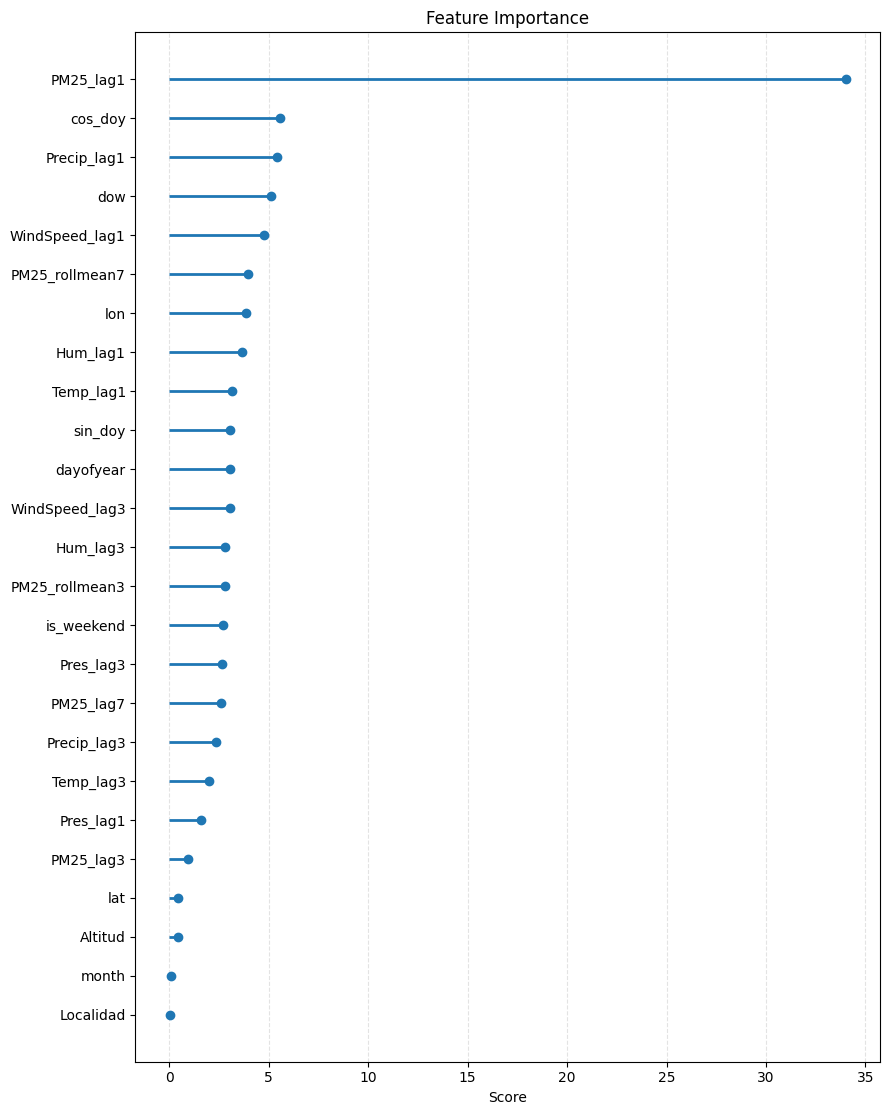

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import Pool

def plot_feature_importance_catboost(model, X, cat_idx=None, top_n=20,
                                     title="Feature Importance"):
    """
    Dibuja un gráfico tipo 'lollipop' horizontal con la importancia de variables
    de un modelo CatBoost ya entrenado.
    - model: CatBoostRegressor/Classifier ya fit.
    - X: DataFrame o ndarray con las features (mismas columnas usadas al entrenar).
    - cat_idx: índices (o nombres) de columnas categóricas si aplica.
    - top_n: cuántas variables más importantes mostrar.
    """
    # Construir Pool para que CatBoost calcule importancias correctamente
    pool = Pool(X, cat_features=cat_idx) if cat_idx is not None else Pool(X)

    # Importancia nativa de CatBoost (Gain por defecto)
    importances = model.get_feature_importance(pool, type='FeatureImportance')

    # Nombres de columnas (si X es ndarray, crear nombres genéricos)
    if hasattr(X, "columns"):
        cols = X.columns.astype(str)
    else:
        cols = pd.Index([f"feature_{i}" for i in range(np.asarray(X).shape[1])], dtype=str)

    fi = (pd.DataFrame({"feature": cols, "importance": importances})
            .sort_values("importance", ascending=False)
            .head(top_n)
            .sort_values("importance", ascending=True))  # para graficar de abajo hacia arriba

    # --- Gráfico estilo “lollipop” horizontal ---
    plt.figure(figsize=(9, max(4, 0.45*len(fi))))
    # líneas
    plt.hlines(y=fi["feature"], xmin=0, xmax=fi["importance"], linewidth=2)
    # puntos
    plt.plot(fi["importance"], fi["feature"], "o")
    # estética
    plt.xlabel("Score")
    plt.ylabel("")
    plt.title(title)
    plt.grid(True, axis="x", linestyle="--", alpha=0.35)
    plt.tight_layout()
    plt.show()

# Ejemplo de uso (con tu modelo final y las columnas de entrenamiento):
plot_feature_importance_catboost(final_model, X_tr, cat_idx=cat_idx, top_n=25)


In [46]:
metrics_te = regression_metrics(y_te, yhat_te)
print("Hold-out 2024 →",
      " | ".join([f"{k}: {metrics_te[k]:.3f}" for k in ["R²","RMSE","MAE","MDAE","MAPE","MPE"]]),
      f"| n_test: {int(mask_test.sum())} (MAPE/MPE con {metrics_te['n_pct_used']} obs.)")


Hold-out 2024 → R²: 0.684 | RMSE: 5.602 | MAE: 4.357 | MDAE: 3.489 | MAPE: 1254.186 | MPE: 1236.247 | n_test: 4571 (MAPE/MPE con 4382 obs.)


In [32]:
# --- 4) R² por estación en hold-out 2024 ---
def eval_r2_by_station(y_true, y_pred, localities):
    """Calcula R² por estación."""
    dfm = pd.DataFrame({"y": y_true, "yhat": y_pred, "Localidad": localities})
    out = []
    for est, g in dfm.groupby("Localidad", sort=False):
        r2 = evaluate_r2(g["y"], g["yhat"])
        out.append({"Localidad": est, "R²": r2, "n": len(g)})
    return pd.DataFrame(out).sort_values("R²", ascending=False)

r2_by_station = eval_r2_by_station(y_te, yhat_te, localities[mask_test])
r2_by_station.round(3)


,Localidad,R²,n
2,Suba,0.728,912
0,Barrios Unidos,0.673,268
6,Engativa,0.671,236
5,Kennedy,0.668,303
8,San Cristobal,0.660,295
7,Santa Fe,0.649,320
10,Usme,0.623,323
3,Fontibon,0.611,642
9,Tunjuelito,0.554,297
1,Ciudad Bolivar,0.548,345


In [33]:
# ===================== BLOQUE A2: Rolling-origin con reentrenamiento por origen =====================
from catboost import CatBoostRegressor, Pool
import numpy as np, pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def rmse_compat(y_true, y_pred):
    try:    return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError: return np.sqrt(mean_squared_error(y_true, y_pred))

# Reconstruye dataset coherente (igual que en el fix anterior)
data_bt = df_ready.dropna(subset=feature_cols + ['PM25']).copy()
X_bt     = data_bt[feature_cols].copy()
y_bt     = data_bt['PM25'].to_numpy()
dates_bt = pd.to_datetime(data_bt['Date'])
cat_features = ['Localidad']

# Orígenes y horizontes
origins  = pd.date_range("2024-01-01", "2024-10-01", freq="MS")
HORIZONS = [1, 7, 14, 30]

# Hiperparámetros (usa los de tu mejor búsqueda si existen)
if "best" in globals() and isinstance(best, dict) and "params" in best:
    bp = best["params"]
    base_params = dict(
        loss_function='RMSE',
        iterations=bp.get("iterations", 2000),
        depth=bp.get("depth", 8),
        learning_rate=bp.get("learning_rate", 0.06),
        l2_leaf_reg=bp.get("l2_leaf_reg", 3.0),
        bootstrap_type='Bayesian',
        bagging_temperature=bp.get("bagging_temperature", 1.0),
        random_strength=bp.get("random_strength", 0.0),
        early_stopping_rounds=100,
        random_seed=42,
        verbose=False,
        allow_writing_files=False
    )
else:
    base_params = dict(
        loss_function='RMSE',
        iterations=2500,
        depth=8,
        learning_rate=0.06,
        l2_leaf_reg=8.0,
        bootstrap_type='Bayesian',
        bagging_temperature=1.0,
        random_strength=0.0,
        early_stopping_rounds=100,
        random_seed=42,
        verbose=False,
        allow_writing_files=False
    )

rows = []
for ori in origins:
    # Entrenamiento con historia hasta el día anterior al origen
    m_train = dates_bt < ori
    if m_train.sum() < 200:
        continue

    X_tr, y_tr = X_bt.loc[m_train], y_bt[m_train.to_numpy()]
    # Early stopping en los últimos ~60 días previos al origen
    dt_tr = dates_bt.loc[m_train]
    if (dt_tr.max() - dt_tr.min()).days < 120:
        m_in  = np.ones(len(X_tr), dtype=bool)
        m_val = np.zeros(len(X_tr), dtype=bool)
    else:
        cutoff = dt_tr.max() - pd.Timedelta(days=60)
        m_in  = (dt_tr <  cutoff).to_numpy()
        m_val = (dt_tr >= cutoff).to_numpy()

    train_pool = Pool(X_tr.loc[m_in],  y_tr[m_in],  cat_features=cat_features)
    valid_pool = Pool(X_tr.loc[m_val], y_tr[m_val], cat_features=cat_features) if m_val.any() else None

    model = CatBoostRegressor(**base_params)
    if valid_pool is not None and m_val.any():
        model.fit(train_pool, eval_set=valid_pool, use_best_model=True, verbose=False)
    else:
        model.fit(train_pool, verbose=False)

    # Ventana a evaluar: [ori, ori+H-1] ∩ 2024
    for H in HORIZONS:
        endH = ori + pd.Timedelta(days=H-1)
        m_eval = (dates_bt >= ori) & (dates_bt <= endH) & (dates_bt.dt.year == 2024)
        if not m_eval.any():
            continue

        X_ev = X_bt.loc[m_eval]
        y_ev = y_bt[m_eval.to_numpy()]
        pool_ev = Pool(X_ev, label=y_ev, cat_features=cat_features)
        yhat = model.predict(pool_ev)

        mae  = mean_absolute_error(y_ev, yhat)
        try:
            rmse = mean_squared_error(y_ev, yhat, squared=False)
        except TypeError:
            rmse = np.sqrt(mean_squared_error(y_ev, yhat))
        r2   = r2_score(y_ev, yhat)

        rows.append([ori.strftime("%Y-%m-%d"), H, int(m_eval.sum()), mae, rmse, r2])

bt2 = pd.DataFrame(rows, columns=["origin","horizon_days","n","MAE","RMSE","R2"])
print("Resumen por horizonte (promedio sobre orígenes):")
display(bt2.groupby("horizon_days")[["MAE","RMSE","R2","n"]].mean().round(3))
bt2.to_csv("backtest_rolling_origin_retrain_2024.csv", index=False)
print("✅ Guardado: backtest_rolling_origin_retrain_2024.csv")


Resumen por horizonte (promedio sobre orígenes):


,MAE,RMSE,R2,n
horizon_days,,,,
1,5.151,6.042,-0.606,12.3
7,3.970,4.984,0.466,86.6
14,4.032,5.060,0.524,173.5
30,4.044,5.117,0.558,372.7


✅ Guardado: backtest_rolling_origin_retrain_2024.csv


In [34]:
# ===================== BLOQUE A2 (COMPLETO): Rolling-origin con reentrenamiento + skill + blend H=1 =====================
from catboost import CatBoostRegressor, Pool
import numpy as np, pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def rmse_compat(y_true, y_pred):
    try:    return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError: return np.sqrt(mean_squared_error(y_true, y_pred))

# --- 0) Reconstruir dataset coherente a partir de tu df_ready / feature_cols ---
data_bt = df_ready.dropna(subset=feature_cols + ['PM25']).copy()
# matrices alineadas
X_bt     = data_bt[feature_cols].copy()
y_bt     = data_bt['PM25'].to_numpy()
dates_bt = pd.to_datetime(data_bt['Date']).copy()
loc_bt   = data_bt['Localidad'].astype(str).copy()

# categóricas por NOMBRE (más robusto si cambian índices)
cat_features = ['Localidad']

# índice booleano para TEST 2024 (lo piden en otros bloques)
test_2024_idx = (dates_bt.dt.year == 2024).to_numpy()

# --- 1) Orígenes y horizontes ---
origins  = pd.date_range("2024-01-01", "2024-10-01", freq="MS")
HORIZONS = [1, 7, 14, 30]

# --- 2) Hiperparámetros base (usa los de tu búsqueda si existen) ---
if "best" in globals() and isinstance(best, dict) and "params" in best:
    bp = best["params"]
    base_params = dict(
        loss_function='MAE',          # MAE mejora robustez para H=1
        eval_metric='MAE',
        iterations=bp.get("iterations", 2000),
        depth=bp.get("depth", 8),
        learning_rate=bp.get("learning_rate", 0.06),
        l2_leaf_reg=bp.get("l2_leaf_reg", 3.0),
        bootstrap_type='Bayesian',
        bagging_temperature=bp.get("bagging_temperature", 1.0),
        random_strength=bp.get("random_strength", 0.0),
        early_stopping_rounds=100,
        random_seed=42,
        verbose=False,
        allow_writing_files=False
    )
else:
    base_params = dict(
        loss_function='MAE',
        eval_metric='MAE',
        iterations=2500,
        depth=8,
        learning_rate=0.06,
        l2_leaf_reg=8.0,
        bootstrap_type='Bayesian',
        bagging_temperature=1.0,
        random_strength=0.0,
        early_stopping_rounds=100,
        random_seed=42,
        verbose=False,
        allow_writing_files=False
    )

# Peso del blend con persistencia para H=1 (ajústalo 0.2–0.6 si quieres)
W_BLEND_H1 = 0.4

rows = []
for ori in origins:
    # --- 3) Ventana de entrenamiento: últimos 365 días antes del origen ---
    m_train_all = (dates_bt < ori)
    if m_train_all.sum() < 120:
        # muy poca historia; saltar este origen
        continue

    # recorta a últimos 365 días
    last_day_train = dates_bt.loc[m_train_all].max()
    cut_start = last_day_train - pd.Timedelta(days=365)
    m_train = m_train_all & (dates_bt >= cut_start)

    X_tr, y_tr = X_bt.loc[m_train], y_bt[m_train.to_numpy()]
    dt_tr = dates_bt.loc[m_train]

    # --- 4) Early stopping: últimos 120 días del entrenamiento como validación ---
    if (dt_tr.max() - dt_tr.min()).days < 180:
        m_in  = np.ones(len(X_tr), dtype=bool)
        m_val = np.zeros(len(X_tr), dtype=bool)
    else:
        cutoff = dt_tr.max() - pd.Timedelta(days=120)
        m_in  = (dt_tr <  cutoff).to_numpy()
        m_val = (dt_tr >= cutoff).to_numpy()

    train_pool = Pool(X_tr.loc[m_in],  y_tr[m_in],  cat_features=cat_features)
    valid_pool = Pool(X_tr.loc[m_val], y_tr[m_val], cat_features=cat_features) if m_val.any() else None

    model = CatBoostRegressor(**base_params)
    if valid_pool is not None and m_val.any():
        model.fit(train_pool, eval_set=valid_pool, use_best_model=True, verbose=False)
    else:
        model.fit(train_pool, verbose=False)

    # --- 5) Evaluación por horizontes en 2024 ---
    for H in HORIZONS:
        endH = ori + pd.Timedelta(days=H-1)
        m_eval = (dates_bt >= ori) & (dates_bt <= endH) & (dates_bt.dt.year == 2024)
        if not m_eval.any():
            continue

        X_ev = X_bt.loc[m_eval]
        y_ev = y_bt[m_eval.to_numpy()]
        pool_ev = Pool(X_ev, label=y_ev, cat_features=cat_features)
        yhat = model.predict(pool_ev)

        # Baseline naive lag-1 (si hay NaN, evalúo skill solo con válidos)
        naive_arr = data_bt.loc[m_eval, 'PM25_lag1'].to_numpy() if 'PM25_lag1' in data_bt.columns else np.full_like(y_ev, np.nan)
        valid_mask = ~np.isnan(naive_arr)
        rmse_naive = rmse_compat(y_ev[valid_mask], naive_arr[valid_mask]) if valid_mask.any() else np.nan

        # Blend con persistencia SOLO para H=1
        if H == 1 and valid_mask.any():
            yhat_blend = yhat.copy()
            yhat_blend[valid_mask] = (1.0 - W_BLEND_H1) * yhat_blend[valid_mask] + W_BLEND_H1 * naive_arr[valid_mask]
            yhat = yhat_blend

        mae  = mean_absolute_error(y_ev, yhat)
        rmse = rmse_compat(y_ev, yhat)
        r2   = r2_score(y_ev, yhat)

        skill = np.nan
        if valid_mask.any() and rmse_naive > 0:
            skill = 1.0 - (rmse / rmse_naive)

        rows.append([ori.strftime("%Y-%m-%d"), H, int(m_eval.sum()), mae, rmse, r2, rmse_naive, skill])

bt2 = pd.DataFrame(rows, columns=["origin","horizon_days","n","MAE","RMSE","R2","RMSE_naive","Skill_vs_naive"])
summary = bt2.groupby("horizon_days")[["MAE","RMSE","R2","RMSE_naive","Skill_vs_naive","n"]].mean().round(3)

print("Resumen por horizonte (promedio sobre orígenes):")
display(summary)
bt2.to_csv("backtest_rolling_origin_retrain_2024.csv", index=False)
summary.to_csv("backtest_rolling_origin_retrain_2024_summary.csv")
print("✅ Guardados: backtest_rolling_origin_retrain_2024.csv, backtest_rolling_origin_retrain_2024_summary.csv")


Resumen por horizonte (promedio sobre orígenes):


,MAE,RMSE,R2,RMSE_naive,Skill_vs_naive,n
horizon_days,,,,,,
1,4.755,5.619,-0.414,5.858,-0.052,12.3
7,4.356,5.388,0.411,5.407,-0.019,86.6
14,4.412,5.495,0.460,5.523,0.005,173.5
30,4.366,5.527,0.498,5.457,0.007,372.7


✅ Guardados: backtest_rolling_origin_retrain_2024.csv, backtest_rolling_origin_retrain_2024_summary.csv


In [35]:
# === FUTURO 2025–2026 A PARTIR DE TU CLIMATOLOGÍA ===
import pandas as pd
import numpy as np

url = "https://raw.githubusercontent.com/Sxmuu/TG-Samuel-P/main/Databases/Climat/Forecast/Forecast_2025-2026.csv"

df_clim = pd.read_csv(url)

In [36]:
# ===================== PROYECCIÓN 2025–2026 DESDE CLIMATOLOGÍA (versión robusta) =====================
import pandas as pd, numpy as np
from collections import deque
from catboost import Pool

# Requisitos ya existentes en tu sesión:
# - df_ready  : con columnas (Date, Estacion, Localidad, lat, lon, Altitud, PM25, ... lags PM25 y meteo)
# - df_clim   : con columnas ['date','station','Temp','Hum','WindSpeed','Precip','Pres'] para 2025–2026
# - final_model : CatBoost entrenado (como en tu notebook)
# - feature_cols: EXACTAMENTE las columnas que tu modelo usa (incluye 'Localidad' + lags PM25 + lags meteo + geo + calendario)

# ---------- 1) Normalizar climatología y unir metadata ----------
future_exo = df_clim.rename(columns={"date":"Date","station":"Estacion"}).copy()
future_exo["Date"] = pd.to_datetime(future_exo["Date"], errors="coerce")

meta_cols = ["Estacion","Localidad","lat","lon","Altitud"]
st_meta = (df_ready[meta_cols]
           .dropna(subset=["Estacion"])
           .drop_duplicates("Estacion"))

future_exo = future_exo.merge(st_meta, on="Estacion", how="left")

# ---------- 2) Calendario base ----------
future_exo["year"]       = future_exo["Date"].dt.year
future_exo["month"]      = future_exo["Date"].dt.month
future_exo["dayofyear"]  = future_exo["Date"].dt.dayofyear
future_exo["dow"]        = future_exo["Date"].dt.dayofweek
future_exo["is_weekend"] = (future_exo["dow"] >= 5).astype(int)
future_exo["sin_doy"]    = np.sin(2*np.pi*future_exo["dayofyear"]/365.25)
future_exo["cos_doy"]    = np.cos(2*np.pi*future_exo["dayofyear"]/365.25)

# ---------- 3) Malla completa fechas × estaciones ----------
all_stations = st_meta["Estacion"].unique()
date_min, date_max = future_exo["Date"].min(), future_exo["Date"].max()
grid = pd.DataFrame({"Date": pd.date_range(date_min, date_max, freq="D")})
grid = grid.assign(key=1).merge(pd.DataFrame({"Estacion": all_stations, "key":1}), on="key").drop(columns="key")

# Unir y añadir metadata sólo si falta para evitar colisiones de columnas
future_exo = grid.merge(future_exo, on=["Date","Estacion"], how="left")
meta_needed = [c for c in ["Localidad","lat","lon","Altitud"] if c not in future_exo.columns]
if meta_needed:
    future_exo = future_exo.merge(st_meta[["Estacion"] + meta_needed], on="Estacion", how="left")

# ---------- 4) Relleno de climatología faltante (Localidad–DOY → Ciudad–DOY → Global) ----------
future_exo["doy"] = future_exo["Date"].dt.dayofyear
met_vars = ["Temp","Hum","WindSpeed","Precip","Pres"]

clim_loc  = (future_exo.groupby(["Localidad","doy"])[met_vars]
             .median().rename(columns={v:f"{v}_loc" for v in met_vars}).reset_index())
clim_city = (future_exo.groupby(["doy"])[met_vars]
             .median().rename(columns={v:f"{v}_city" for v in met_vars}).reset_index())

future_exo = future_exo.merge(clim_loc,  on=["Localidad","doy"], how="left") \
                       .merge(clim_city, on=["doy"],        how="left")

glob_med = future_exo[met_vars].median(numeric_only=True)

for v in met_vars:
    future_exo[v] = (future_exo[v]
                     .fillna(future_exo[f"{v}_loc"])
                     .fillna(future_exo[f"{v}_city"])
                     .fillna(glob_med[v]))

# ---------- 5) Lags de meteo (lag1, lag3) por estación ----------
future_exo = future_exo.sort_values(["Estacion","Date"]).reset_index(drop=True)
for v in met_vars:
    future_exo[f"{v}_lag1"] = future_exo.groupby("Estacion", sort=False)[v].shift(1)
    future_exo[f"{v}_lag3"] = future_exo.groupby("Estacion", sort=False)[v].shift(3)

# Relleno suave de los primeros días (mantiene índice; evita errores de asignación)
future_exo["Estacion"] = future_exo["Estacion"].astype(str)
future_exo = future_exo.sort_values(["Estacion","Date"]).reset_index(drop=True)
for v in met_vars:
    for k in [1, 3]:
        col = f"{v}_lag{k}"
        if col in future_exo.columns:
            future_exo[col] = (
                future_exo
                .groupby("Estacion", sort=False)[col]
                .transform(lambda s: s.bfill().ffill())
                .astype("float64")
            )

# ---------- 6) Saneo categóricas: asegurar Localidad sin NaN (CatBoost lo exige) ----------
# Mapa Estacion->Localidad desde histórico
st2loc = (df_ready[['Estacion','Localidad']]
          .dropna()
          .drop_duplicates('Estacion')
          .set_index('Estacion')['Localidad']
          .to_dict())

future_exo['Localidad'] = future_exo['Localidad'].fillna(
    future_exo['Estacion'].map(st2loc)
)
future_exo['Localidad'] = future_exo['Localidad'].fillna('UNKNOWN').astype(str)

# Si prefieres no predecir con UNKNOWN, descomenta:
# future_exo = future_exo[future_exo['Localidad'] != 'UNKNOWN'].copy()

cat_feats = ['Localidad']  # usaremos nombres de columnas para CatBoost

# ---------- 7) Semilla de lags PM25 (buffer por estación con últimos 7 días de 2024) ----------
hist_buffers = {}
for st, g in df_ready.sort_values(["Estacion","Date"]).groupby("Estacion", sort=False):
    tail = g["PM25"].tail(7).tolist()
    if len(tail) < 7:
        tail = [np.nan]*(7-len(tail)) + tail
    hist_buffers[st] = deque(tail, maxlen=7)

# ---------- 8) Proyección recursiva 2025–2026 ----------
future_days = sorted(future_exo["Date"].unique())
pred_rows = []

for d in future_days:
    day = future_exo[future_exo["Date"] == d]
    for st, g in day.groupby("Estacion"):
        if st not in hist_buffers:
            continue

        buf = hist_buffers[st].copy()

        # Lags PM25 desde el buffer
        pm25_lag1 = buf[-1] if len(buf)>=1 else np.nan
        pm25_lag3 = buf[-3] if len(buf)>=3 else np.nan
        pm25_lag7 = buf[0]  if len(buf)>=7 else np.nan
        roll3     = np.nanmean([x for x in list(buf)[-3:] if pd.notna(x)]) if len(buf) else np.nan
        roll7     = np.nanmean([x for x in list(buf)      if pd.notna(x)]) if len(buf) else np.nan

        row = g.iloc[0].copy()
        row["PM25_lag1"] = pm25_lag1
        row["PM25_lag3"] = pm25_lag3
        row["PM25_lag7"] = pm25_lag7
        row["PM25_rollmean3"] = roll3
        row["PM25_rollmean7"] = roll7

        # Construir X EXACTAMENTE con tus 'feature_cols'
        x = row.reindex(feature_cols, fill_value=np.nan)

        # ---- Blindaje categóricas por-fila (sin NaN, tipo str) ----
        X_row = pd.DataFrame([x.values], columns=feature_cols)
        for c in cat_feats:
            if c in X_row.columns:
                if pd.isna(X_row.loc[0, c]):  # fallback extra
                    X_row.loc[0, c] = st2loc.get(row['Estacion'], 'UNKNOWN')
                X_row[c] = X_row[c].astype(str)

        # (Opcional) saltar filas UNKNOWN
        # if any(X_row[c].iloc[0] == 'UNKNOWN' for c in cat_feats):
        #     continue

        # Predecir con CatBoost usando nombres de columnas categóricas
        pool = Pool(X_row, cat_features=cat_feats)
        yhat = float(final_model.predict(pool))

        pred_rows.append({"Date": d, "Estacion": row["Estacion"], "Localidad": row["Localidad"], "PM25_pred": yhat})
        hist_buffers[st].append(yhat)  # actualización recursiva

pred_df = pd.DataFrame(pred_rows).sort_values(["Estacion","Date"]).reset_index(drop=True)

# ---------- 9) Agregar por Localidad (mediana de estaciones) y guardar ----------
pred_loc = (pred_df.groupby(["Date","Localidad"])["PM25_pred"]
            .median().rename("PM25_pred_mediana").reset_index())

pred_df.to_csv("proyecciones_pm25_2025_2026_por_estacion.csv", index=False)
pred_loc.to_csv("proyecciones_pm25_2025_2026_por_localidad.csv", index=False)
print("✅ Guardados: proyecciones_pm25_2025_2026_por_estacion.csv, proyecciones_pm25_2025_2026_por_localidad.csv")
display(pred_df.head(), pred_loc.head())


Se truncaron las últimas líneas 5000 del resultado de transmisión.
/tmp/ipython-input-2146824829.py:153: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(final_model.predict(pool))
/tmp/ipython-input-2146824829.py:153: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(final_model.predict(pool))
/tmp/ipython-input-2146824829.py:153: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(final_model.predict(pool))
/tmp/ipython-input-2146824829.

✅ Guardados: proyecciones_pm25_2025_2026_por_estacion.csv, proyecciones_pm25_2025_2026_por_localidad.csv


/tmp/ipython-input-2146824829.py:153: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(final_model.predict(pool))
/tmp/ipython-input-2146824829.py:153: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(final_model.predict(pool))
/tmp/ipython-input-2146824829.py:153: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(final_model.predict(pool))
/tmp/ipython-input-2146824829.py:153: DeprecationWarning: Conversion of an array with ndim > 0 to

,Date,Estacion,Localidad,PM25_pred
0,2025-01-01,Centro De Alto Rendimiento,Barrios Unidos,15.201712
1,2025-01-02,Centro De Alto Rendimiento,Barrios Unidos,17.839837
2,2025-01-03,Centro De Alto Rendimiento,Barrios Unidos,19.370205
3,2025-01-04,Centro De Alto Rendimiento,Barrios Unidos,19.630409
4,2025-01-05,Centro De Alto Rendimiento,Barrios Unidos,19.096902


,Date,Localidad,PM25_pred_mediana
0,2025-01-01,Barrios Unidos,15.201712
1,2025-01-01,Ciudad Bolivar,21.949846
2,2025-01-01,Engativa,17.449897
3,2025-01-01,Fontibon,17.374677
4,2025-01-01,Kennedy,18.055756
